<a href="https://colab.research.google.com/github/lukehartfield/DemandNonLinearOptimization/blob/main/Optimization_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 23.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Load the data
df = pd.read_csv('price_demand_data.csv')

## Part 1:

In [ ]:
# Fit regression
X = df[['price']]
y = df['demand']

reg = LinearRegression()
reg.fit(X, y)

beta_0 = reg.intercept_
beta_1 = reg.coef_[0]

# Get residuals
residuals = y - (beta_0 + beta_1 * X['price'])

print(f"beta_0 = {beta_0:.4f}, beta_1 = {beta_1:.4f}")

beta_0 = 1924.7175, beta_1 = -1367.7125


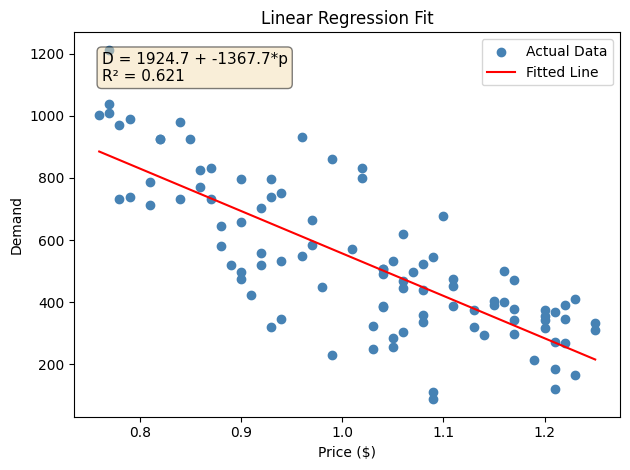

In [ ]:
# Plot linear regression
plt.scatter(df['price'], df['demand'],label='Actual Data', color='steelblue')
price_range = np.linspace(df['price'].min(), df['price'].max(), 100)
predicted_demand = beta_0 + beta_1 * price_range
plt.plot(price_range, predicted_demand, 'r-', label='Fitted Line')
plt.xlabel('Price ($)')
plt.ylabel('Demand')
plt.title('Linear Regression Fit')
plt.legend()
plt.text(0.05, 0.95, f'D = {beta_0:.1f} + {beta_1:.1f}*p\nR² = {reg.score(X, y):.3f}',
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

## Part 2:

In [ ]:
# Generating Demand Data
p = 1
c = 0.5
g = 0.75
t = 0.15

demand_data = beta_0 + beta_1 * p + residuals
demand_data.mean()

np.float64(557.0050193665105)

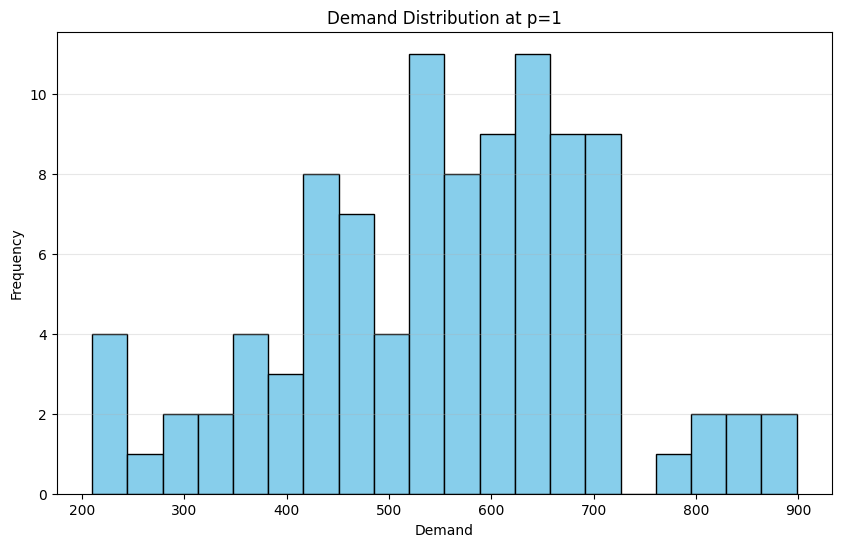

In [ ]:
# Demand Distribution
plt.figure(figsize=(10, 6))
plt.hist(demand_data, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.title('Demand Distribution at p=1')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

## Part 3:

In [ ]:
# Solve optimal quantity to produce when p = 1  (LP)

m = gp.Model("newsvendor_q_only")
m.setParam('OutputFlag', 0)

p = 1  # price is fixed at 1

# Decision variable: quantity to produce
q = m.addVar(lb=0, name="q")

n = len(demand_data)

# h[i] = profit in each scenario
h = m.addVars(n, lb=-GRB.INFINITY, name="h")

# dplus[i] = shortage amount max(D_i - q, 0)
# excess[i] = surplus amount max(q - D_i, 0)
dplus = m.addVars(n, lb=0, name="dplus")
excess = m.addVars(n, lb=0, name="excess")

# Constraints
for i in range(n):
    D_i = demand_data.iloc[i]  # use .iloc in case demand_data is a Series

    # Define shortage and surplus
    m.addConstr(dplus[i] >= D_i - q)
    m.addConstr(excess[i] >= q - D_i)

    # Profit for each scenario:
    # revenue from selling D_i units
    # minus regular production cost for q
    # minus rush cost for shortage
    # minus disposal cost for surplus
    m.addConstr(
        h[i] <= p * D_i - c * q - g * dplus[i] - t * excess[i],
        name=f"profit_scenario_{i}"
    )

# Objective: maximize expected (average) profit
m.setObjective((1 / n) * gp.quicksum(h[i] for i in range(n)), GRB.MAXIMIZE)

# Solve
m.optimize()

print(f"Optimal quantity to produce (q*): {q.X:.4f}")
print(f"Expected average profit: ${m.ObjVal:.2f}")

Optimal quantity to produce (q*): 471.8654
Expected average profit: $231.48


## Part 4:

In [ ]:
# ===== Q4 – Joint price & quantity optimization (QP, same as your friend) =====

b0 = beta_0          # just renaming to match notation
b1 = beta_1
n  = len(residuals)

m2 = gp.Model("newsvendor_qp")
m2.setParam('OutputFlag', 0)   # silence solver

# Decision variables
p_var = m2.addVar(lb=0.0, name="price")     # price p ≥ 0
q_var = m2.addVar(lb=0.0, name="quantity")  # quantity q ≥ 0

# h_i = negative cost in scenario i (≤ 0)
h = m2.addVars(n, lb=-GRB.INFINITY, ub=0.0, name="neg_cost")

# ---- Objective: average revenue + average negative cost ----
# Average revenue: (1/n) * Σ p * (b0 + b1*p + eps_i)
avg_revenue = (1.0 / n) * gp.quicksum(
    p_var * (b0 + b1 * p_var + residuals.iloc[i]) for i in range(n)
)

# Average negative cost: (1/n) * Σ h_i
avg_neg_cost = (1.0 / n) * gp.quicksum(h[i] for i in range(n))

m2.setObjective(avg_revenue + avg_neg_cost, GRB.MAXIMIZE)

# ---- Constraints to define h_i as the negative cost ----
for i in range(n):
    eps_i = residuals.iloc[i]

    # D_i = b0 + b1*p + eps_i, but we substitute it out algebraically

    # Shortage case: h_i <= q(g - c) - g*D_i
    #              = q(g - c) - g(b0 + b1*p + eps_i)
    m2.addConstr(
        h[i] <= q_var * (g - c) - g * b1 * p_var - g * b0 - g * eps_i,
        name=f"neg_cost_short_{i}"
    )

    # Surplus case: h_i <= -q(c + t) + t*D_i
    #             = -q(c + t) + t(b0 + b1*p + eps_i)
    m2.addConstr(
        h[i] <= -q_var * (c + t) + t * b1 * p_var + t * b0 + t * eps_i,
        name=f"neg_cost_surplus_{i}"
    )

# ---- Solve ----
m2.optimize()

print("Quadratic Programming Results (QP)")
if m2.Status == GRB.OPTIMAL:
    p_opt_qp = p_var.X
    q_opt_qp = q_var.X
    profit_opt_qp = m2.ObjVal

    print(f"Optimal Price (p*) = {p_opt_qp:.4f}")
    print(f"Optimal Quantity (q*) = {q_opt_qp:.4f}")
    print(f"Expected Average Profit = {profit_opt_qp:.4f}")
else:
    print("Optimization was not successful.")

Quadratic Programming Results (QP)
Optimal Price (p*) = 0.9536
Optimal Quantity (q*) = 535.2910
Expected Average Profit = 234.4249


## Part 6:


number of successful bootstrap runs: 200 out of 200

bootstrap summary for optimal price:
  mean: 0.9447
  std:  0.0119
  2.5th percentile: 0.9220
  97.5th percentile: 0.9665

bootstrap summary for optimal quantity:
  mean: 698.5092
  std:  31.8280
  2.5th percentile: 636.5265
  97.5th percentile: 753.8998

bootstrap summary for expected profit:
  mean: 185.0307
  std:  12.3990
  2.5th percentile: 163.4827
  97.5th percentile: 207.9795


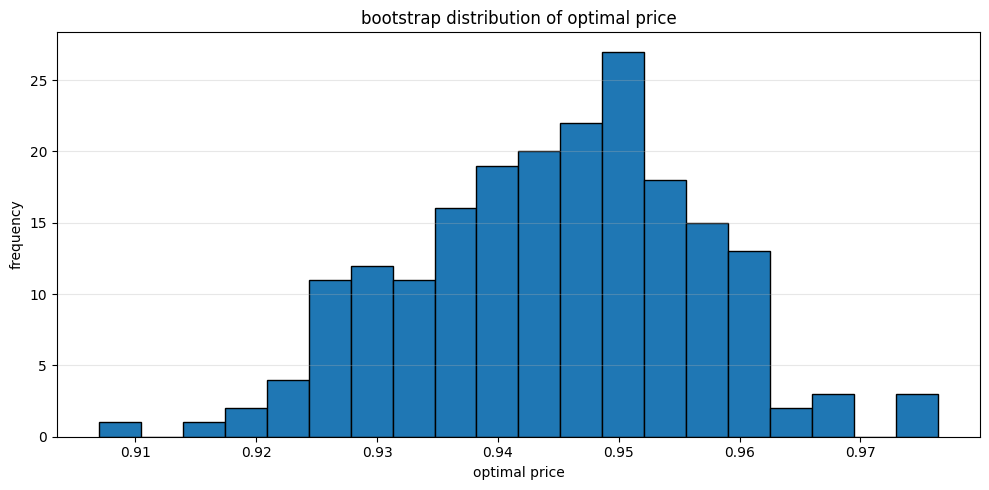

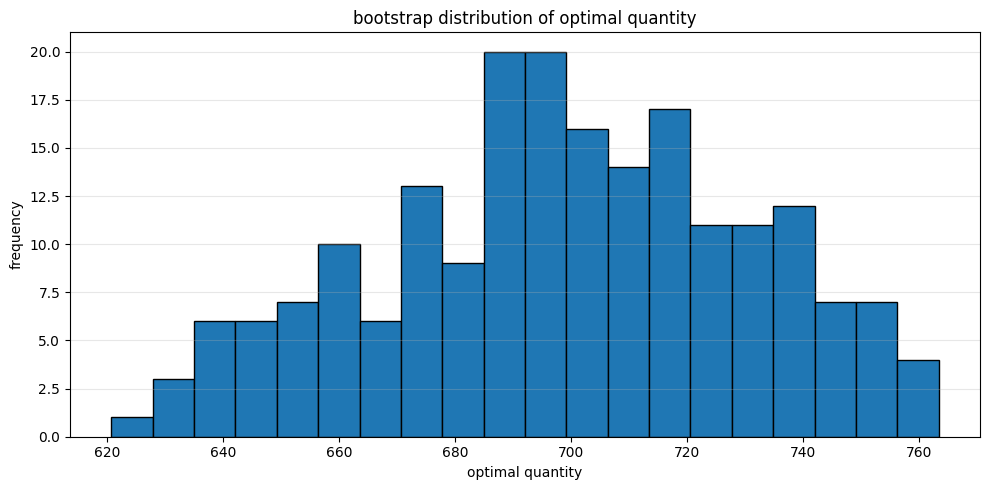

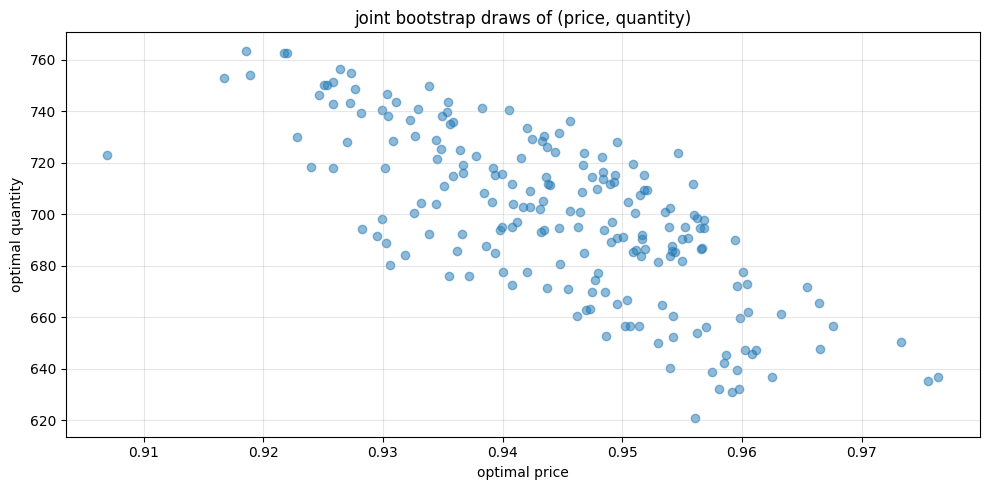

In [ ]:
## Part 6: bootstrap sensitivity of optimal price and quantity

# number of bootstrap replications
B = 200

p_boot = []
q_boot = []
profit_boot = []

for b in range(B):
    # sample rows with replacement from the original dataset
    boot_idx = np.random.choice(df.index, size=len(df), replace=True)
    df_boot = df.loc[boot_idx].reset_index(drop=True)

    # refit linear regression on the bootstrapped sample
    X_boot = df_boot[['price']]
    y_boot = df_boot['demand']

    reg_boot = LinearRegression()
    reg_boot.fit(X_boot, y_boot)

    beta_0_b = reg_boot.intercept_
    beta_1_b = reg_boot.coef_[0]

    # compute residuals for the bootstrapped sample
    residuals_boot = y_boot - (beta_0_b + beta_1_b * X_boot['price'])

    # build gurobi model for joint optimization of price and quantity (same structure as part 4)
    m_b = gp.Model()
    m_b.setParam('OutputFlag', 0)
    m_b.setParam('NonConvex', 2)  # allow bilinear / quadratic terms

    # decision variables: price and quantity
    p_b = m_b.addVar(lb=df['price'].min(), ub=df['price'].max(), name=f"p_{b}")
    q_b = m_b.addVar(lb=0, name=f"q_{b}")

    n_b = len(residuals_boot)
    h_b = m_b.addVars(n_b, lb=-GRB.INFINITY, name=f"h_{b}")  # profit per scenario

    for i in range(n_b):
        eps_i = residuals_boot.iloc[i]

        # demand as a function of price for this bootstrap sample
        D_i_b = beta_0_b + beta_1_b * p_b + eps_i

        # case 1: q <= D_i (sell q, rush order the rest)
        # profit = p*q - c*q - g*(D_i - q)
        m_b.addConstr(h_b[i] <= p_b * q_b - c * q_b - g * (D_i_b - q_b))

        # case 2: q > D_i (overproduce and pay disposal cost)
        # profit = p*D_i - c*q - t*(q - D_i)
        m_b.addConstr(h_b[i] <= p_b * D_i_b - c * q_b - t * (q_b - D_i_b))

    # objective: maximize expected profit (average over all scenarios)
    m_b.setObjective(sum(h_b[i] for i in range(n_b)) / n_b, GRB.MAXIMIZE)

    m_b.optimize()

    # store results if this bootstrap problem solved optimally
    if m_b.status == GRB.OPTIMAL:
        p_boot.append(p_b.X)
        q_boot.append(q_b.X)
        profit_boot.append(m_b.objVal)
    else:
        print(f"bootstrap iteration {b} did not solve to optimality, status code: {m_b.status}")

# convert lists to numpy arrays for analysis
p_boot = np.array(p_boot)
q_boot = np.array(q_boot)
profit_boot = np.array(profit_boot)

print(f"\nnumber of successful bootstrap runs: {len(p_boot)} out of {B}")

# summary statistics for optimal price and quantity
print("\nbootstrap summary for optimal price:")
print(f"  mean: {p_boot.mean():.4f}")
print(f"  std:  {p_boot.std(ddof=1):.4f}")
print(f"  2.5th percentile: {np.percentile(p_boot, 2.5):.4f}")
print(f"  97.5th percentile: {np.percentile(p_boot, 97.5):.4f}")

print("\nbootstrap summary for optimal quantity:")
print(f"  mean: {q_boot.mean():.4f}")
print(f"  std:  {q_boot.std(ddof=1):.4f}")
print(f"  2.5th percentile: {np.percentile(q_boot, 2.5):.4f}")
print(f"  97.5th percentile: {np.percentile(q_boot, 97.5):.4f}")

print("\nbootstrap summary for expected profit:")
print(f"  mean: {profit_boot.mean():.4f}")
print(f"  std:  {profit_boot.std(ddof=1):.4f}")
print(f"  2.5th percentile: {np.percentile(profit_boot, 2.5):.4f}")
print(f"  97.5th percentile: {np.percentile(profit_boot, 97.5):.4f}")

# plots for pdf report

plt.figure(figsize=(10, 5))
plt.hist(p_boot, bins=20, edgecolor='black')
plt.xlabel('optimal price')
plt.ylabel('frequency')
plt.title('bootstrap distribution of optimal price')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(q_boot, bins=20, edgecolor='black')
plt.xlabel('optimal quantity')
plt.ylabel('frequency')
plt.title('bootstrap distribution of optimal quantity')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(p_boot, q_boot, alpha=0.5)
plt.xlabel('optimal price')
plt.ylabel('optimal quantity')
plt.title('joint bootstrap draws of (price, quantity)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Part 7:


bootstrap summary for expected profit:
  mean: 185.0307
  std:  12.3990
  2.5th percentile: 163.4827
  97.5th percentile: 207.9795


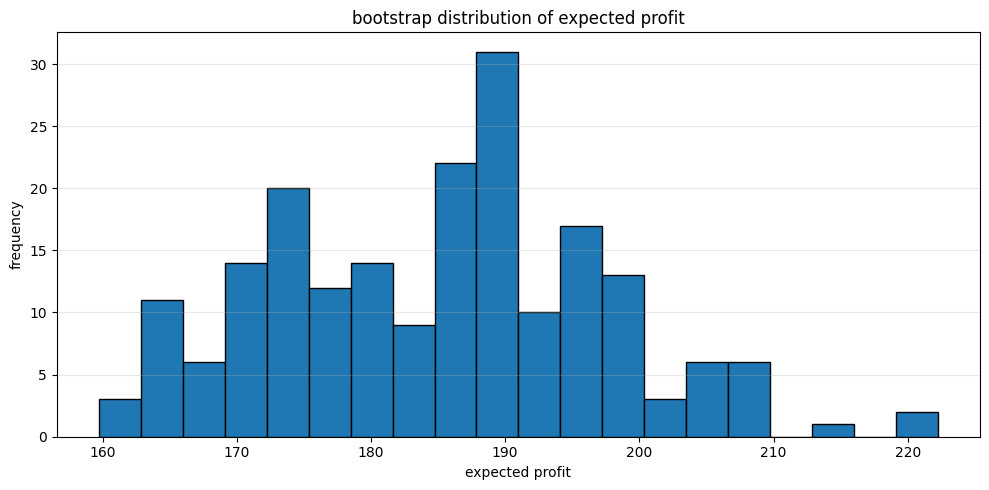

In [ ]:


# === summary statistics for expected profit ===
print("\nbootstrap summary for expected profit:")
print(f"  mean: {profit_boot.mean():.4f}")
print(f"  std:  {profit_boot.std(ddof=1):.4f}")
print(f"  2.5th percentile: {np.percentile(profit_boot, 2.5):.4f}")
print(f"  97.5th percentile: {np.percentile(profit_boot, 97.5):.4f}")

# === histogram of expected profit ===
plt.figure(figsize=(10, 5))
plt.hist(profit_boot, bins=20, edgecolor='black')
plt.xlabel('expected profit')
plt.ylabel('frequency')
plt.title('bootstrap distribution of expected profit')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


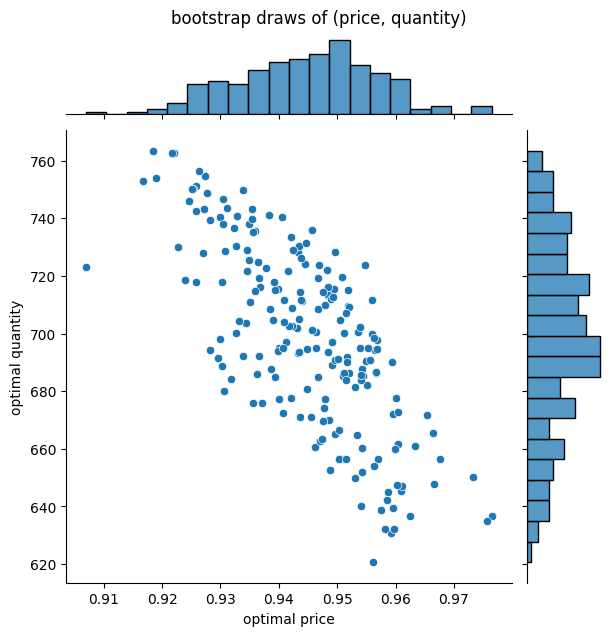

In [ ]:
import seaborn as sns

sns.jointplot(x=p_boot, y=q_boot, kind='scatter',
              marginal_kws={'bins': 20, 'fill': True})
plt.xlabel('optimal price')
plt.ylabel('optimal quantity')
plt.suptitle('bootstrap draws of (price, quantity)', y=1.02)
plt.show()
